# P3 Concevez une application au service de la santé publique 

L'agence <span style='color:blue'> <a href = "http://www.santepubliquefrance.fr/">"*Santé publique France*" </a></span> a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. <br>
Vous souhaitez y participer et proposer une idée d’application.

Le jeu de données <font color='orange'>Open Food Facts</font> est disponible sur le <a href = "https://world.openfoodfacts.org/">site officiel</a> (ou disponible à <a href ="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip">ce lien</a> en téléchargement).
<br>
Les variables sont définies à <a href = "https://world.openfoodfacts.org/data/data-fields.txt">cette adresse</a>

Les champs sont séparés en quatre sections :

- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

Notre idée est de créer une application mobile nommé livebetterandlonger

Cette application permettra au utilisateur d'ameliorer leur alimentaion, en leur proposant lors de l'achat des course d'obtenir une liste de produit similaire plus sain, c'est à dire en terme possedant un meilleur nutriscore. 


Comment:
lors de la selection d'un aliment, grace à son smartphone le client scannera le code barre de l'aliment, et obtiendra une liste de produit ordonnée par qualité nutritive au moins aussi interressant que le produit scanné.

Ce notebook a pour vocation à détailler le processus de nettoyage et de traitement necessaire pour la mise en place de notre application lookalike.

Les données sont toutes issues de l'initiative Open Food Facts dans le cadre de l'appel à projets de l'Agence Santé Publique France.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os

import missingno as msno

In [2]:
%%time
if os.path.exists("fr.openfoodfacts.org.products.csv"):
    openfoodfacts = pd.read_csv("fr.openfoodfacts.org.products.csv",sep='\t',low_memory=False)

CPU times: total: 28.9 s
Wall time: 29.1 s


prendre 1 echant en parametre / 
figer typ de chaq col

In [3]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Le fichier comtient 106 variables numeriques et 56 varriables catégoriques.
Il y a trop de données pour tout afficher dans une cellule resultant de la methode info().
Nous etudirons les colonnes de type 'object' dans un premier temps.

In [4]:
pd.options.display.max_columns=60
openfoodfacts[openfoodfacts.columns[(openfoodfacts.dtypes==object) ].to_list()].describe().T

,count,unique,top,freq
code,320749,320749,0000000003087,1
url,320749,320749,http://world-fr.openfoodfacts.org/produit/0000...,1
creator,320770,3535,usda-ndb-import,169868
created_t,320769,189567,1489077120,20
created_datetime,320763,189568,2017-03-09T10:37:09Z,20
last_modified_t,320772,180495,1439141742,33
last_modified_datetime,320772,180495,2015-08-09T17:35:42Z,33
product_name,303010,221347,Ice Cream,410
generic_name,52795,38584,Pâtes alimentaires au blé dur de qualité supér...,201
quantity,104819,13826,500 g,4669


In [5]:
def test_na_nunique(col1,col2):
    '''
    Test number of Missing Value et number unique value
    '''
    return(col1.nunique() < col2.nunique() and abs(col1.notna().sum() - col2.notna().sum() ) <100)

def drop_duplicated_col(df):
    '''
    return list columns redundant to drop
    '''
    col_to_drop = []
    
    for col in df.columns :

        # les dates
        if len(col.split('_'))>=2 and col.split('_')[-1] == 't':  
            col_to_drop.append(col.replace('_t','_datetime'))


        if len(col.split('_'))==1 and col+'_fr' in openfoodfacts and col+'_tags' in openfoodfacts:
            # si 'fr' better than ''
            col_to_drop.extend(np.where(test_na_nunique(df[col+'_fr'] , df[col]), 
                                        np.where(test_na_nunique( df[col+'_fr'] , df[col+'_tags'] ),
                                                 [col,col+'_tags'],   # si 'fr'> '_tags' 
                                                 [col,col+'_fr']      # si 'fr'< '_tags' 
                                                ),
                                        # si 'fr' not better than ''
                                        np.where(test_na_nunique(df[col] , df[col+'_tags'] ),
                                                 [col+'_tags',col+'_fr'],
                                                 [col ,col+'_fr']
                                                )
                                       )
                              )
        elif len(col.split('_'))==1 and (col+'_fr' in openfoodfacts or col+'_tags' in openfoodfacts):

            if col+'_fr' in openfoodfacts:  
                col_to_drop.extend(np.where(test_na_nunique(df[col+'_fr'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col+'_fr']      # si 'fr'< '' 
                                           )
                                  )

            elif col+'_tags' in openfoodfacts:
                # si 'fr' better than ''
                col_to_drop.extend(np.where(test_na_nunique(df[col+'_tags'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col+'_tags']      # si 'fr'< '' 
                                           )
                                  )
        elif len(col.split('_'))>=2 and col +'_fr' in openfoodfacts or col+'_tags' in openfoodfacts:
            
            if (col+'_fr' in openfoodfacts) :
                col_to_drop.extend(np.where(test_na_nunique(df[col ] , df[col+'_fr']),
                                            [col+ '_fr'],   # si 'fr'> ''
                                            [col ]      # si 'fr'< '' 
                                           )
                                  )

            elif (col +'_tags' in openfoodfacts) :
                # si 'fr' better than ''
                col_to_drop.extend(np.where(test_na_nunique(df[col + '_tags'] , df[col]),
                                            [col],   # si 'fr'> ''
                                            [col +'_tags']      # si 'fr'< '' 
                                           )
                                  )
 
            
    return col_to_drop

In [6]:
list_col_to_drop = drop_duplicated_col(df = openfoodfacts)
list_col_to_drop

['created_datetime',
 'last_modified_datetime',
 'packaging',
 'brands',
 'categories',
 'categories_fr',
 'origins',
 'manufacturing_places',
 'labels',
 'labels_fr',
 'emb_codes',
 'cities_tags',
 'countries',
 'countries_tags',
 'allergens_fr',
 'traces',
 'traces_fr',
 'additives',
 'additives_fr',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_tags',
 'states',
 'states_fr',
 'main_category']

In [7]:
data_cleaned = openfoodfacts.drop(columns=list_col_to_drop)

In [8]:
data_cleaned.head()

,code,url,creator,created_t,last_modified_t,product_name,generic_name,quantity,packaging_tags,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,labels_tags,emb_codes_tags,first_packaging_code_geo,cities,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_tags,serving_size,no_nutriments,additives_n,additives_tags,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,...,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,1474103893,Farine de blé noir,NaN,1kg,NaN,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,1489069957,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,28 g (1 ONZ),NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,1489069957,Peanuts,NaN,NaN,NaN,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,28 g (0.25 cup),NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,1489055731,Organic Salted Nut Mix,NaN,NaN,NaN,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,28 g (0.25 cup),NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,1489055653,Organic Polenta,NaN,NaN,NaN,bob-s-red-mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,États-Unis,Organic polenta,NaN,NaN,35 g (0.25 cup),NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
nbLigne, nbCol = data_cleaned.shape

In [10]:
print ("Le dataset compte {} lignes et {} colonnes".format( nbLigne , nbCol ))

Le dataset compte 320772 lignes et 138 colonnes


### Etude du nombre de valeurs manquantes

In [11]:
pd.set_option("display.max_rows", 200) #parametre le nombre de ligne affichable dans dataframe pandas
pd.set_option("expand_frame_repr", True) #permet de deplier les colonnes cachées
pd.set_option("display.max_columns",200 ) #permet d'afficher jusqu'à 200 colonnes dans une cellule

In [12]:
print('Au total le dataset possede {} valeurs manquantes. \nCe qui represante {:.2%} des valeurs du dataset'.format(data_cleaned.isna().sum().sum(),data_cleaned.isna().sum().sum()/(nbCol*nbLigne)))

Au total le dataset possede 35128921 valeurs manquantes. 
Ce qui represante 79.36% des valeurs du dataset


In [13]:
def compute_nb_mising_values(data):
    """
    Cree un dataframe pandas qui contient le nombre de valeurs par colonnes de l'argument data
    """
    valeurs = {}
    
    for col in data.columns:
        valeurs[col] = []
        valeurs[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        valeurs[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=valeurs, orient='index',
                                  columns = ["Taux de valeurs non nulles", "Nombre de valeurs manquantes"]
                                 ).sort_values(by="Nombre de valeurs manquantes",ascending=True)

In [14]:
compute_nb_mising_values(data_cleaned)

,Taux de valeurs non nulles,Nombre de valeurs manquantes
last_modified_t,100.00,0
creator,100.00,2
created_t,100.00,3
code,99.99,23
url,99.99,23
states_tags,99.99,46
countries_fr,99.91,280
product_name,94.46,17762
brands_tags,91.14,28420
energy_100g,81.40,59659


On voit que 23 produits ne possède pas de code bar.

In [15]:
data_cleaned[data_cleaned.code.isnull()][['generic_name']]

,generic_name
189068,"Lait entier, fruits : fraise (20 %), mangue (1..."
189103,"_Lait_ entier (59,5 %), _lait_ écrémé concentr..."
189109,"Lait entier 69.5 %, fruits : fraise 10 %, mang..."
189119,"_Lait_ entier (78%), fruits : mangue, abricot..."
189152,"_Lait_ écrémé, _lait_ écrémé concentré ou en p..."
189160,"_Lait_ écrémé, fruits : fraise (12 %), cerise ..."
189162,"_Lait_ écrémé, _lait_ écrémé concentré ou en p..."
189168,"_Lait_ entier (59,5 %), _lait_ écrémé concentr..."
189242,"_Lait_ entier, rhubarbe (8 %), sucre (8 %), la..."
189244,"_Lait_ entier, ananas (8 %), sucre (7,1 %), _l..."


Ce sont des produits laitiers. Peut etre qu'il faut les supprimer.

In [16]:
data_cleaned = data_cleaned.loc[~data_cleaned.code.isna()]

In [17]:
nbLigne, nbCol = data_cleaned.shape
nbLigne, nbCol

(320749, 138)

In [18]:
compute_nb_mising_values(data_cleaned)

,Taux de valeurs non nulles,Nombre de valeurs manquantes
code,100.00,0
url,100.00,0
created_t,100.00,0
last_modified_t,100.00,0
creator,100.00,2
states_tags,99.99,23
countries_fr,99.91,280
product_name,94.46,17762
brands_tags,91.15,28397
energy_100g,81.41,59636


In [19]:
data_cleaned.dropna(axis='columns' , thresh= round(nbLigne * 0.0005),inplace = True)
compute_nb_mising_values( data_cleaned )

,Taux de valeurs non nulles,Nombre de valeurs manquantes
code,100.00,0
url,100.00,0
created_t,100.00,0
last_modified_t,100.00,0
creator,100.00,2
states_tags,99.99,23
countries_fr,99.91,280
product_name,94.46,17762
brands_tags,91.15,28397
energy_100g,81.41,59636


In [20]:
print('Avec un seuil de {} lignes {} ont été supprimées et maintenant le dataset possède {} colonnes'.format(round(nbLigne * 0.0005),(nbCol-data_cleaned.shape[1]),data_cleaned.shape[1]))

Avec un seuil de 160 lignes 53 ont été supprimées et maintenant le dataset possède 85 colonnes


In [21]:
nbLigne, nbCol = data_cleaned.shape
nbLigne, nbCol

(320749, 85)

### Etudes des Doublons de la cle primaire/ du dataset

In [22]:
print('Le dataset possedent {} lignes de doublons.'.format(data_cleaned.duplicated().sum()))

Le dataset possedent 0 lignes de doublons.


In [23]:
print('Le taux de doublons de valeurs est de {} %.'.format(100 - round(data_cleaned.code.nunique()*100/data_cleaned.shape[0],2)) )

Le taux de doublons de valeurs est de 0.0 %.


On ne trouve pas de valeurs manquantes.
Il y a-t'il des erreurs?

In [24]:
data_cleaned.code.str.replace('[a-zA-Z]','A',regex=True).str.replace('[0-9]','N',regex=True).value_counts()

NNNNNNNNNNNNN                                302985
NNNNNNNN                                      13851
NNNNNNNNNNN                                    2322
NNNNNNNNNNNN                                    825
NNNNNNNNNNNNNN                                  253
NNNNNNNNNN                                      136
NNNNNNN                                          96
NNNNNN                                           67
NNNN                                             34
NNNNNNNNNNNNNNN                                  31
NNNNNNNNNNNNNNNNNNNNNNNN                         31
NNNNN                                            20
NNNNNNNNNNNNNNNNNN                               20
NNNNNNNNN                                        18
NNNNNNNNNNNNNNNN                                 13
NNN                                               8
NNNNNNNNNNNNNNNNNNNNNN                            7
NN                                                7
NNNNNNNNNNNNNNNNNNNNNNNNNN                        5
N           

In [25]:
print('{} % des codes sont maintenant confondu avec un autre code'.format(round(1- data_cleaned.code.str.zfill(41).nunique() / data_cleaned.code.nunique(),4) ))

0.0005 % des codes sont maintenant confondu avec un autre code


</br>

</br>

# Etude des types de variables

In [26]:
pd.options.display.max_rows,pd.options.display.max_columns

(200, 200)

In [27]:
nomColonnes = pd.DataFrame({'Colonnes':data_cleaned.columns})
nomColonnes.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
Colonnes,code,url,creator,created_t,last_modified_t,product_name,generic_name,quantity,packaging_tags,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,labels_tags,emb_codes_tags,first_packaging_code_geo,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_tags,serving_size,additives_n,additives_tags,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_tags,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,potassium_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g


In [28]:
openfoodfacts.columns[52:54]

Index(['nutrition_grade_uk', 'nutrition_grade_fr'], dtype='object')

In [29]:
# Categoriser les types de colonnes
# info general
general_information = [x for x in nomColonnes.Colonnes.values.tolist() if x in ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity']]

# tags
tags = [x for x in nomColonnes.Colonnes.values.tolist() if x in ['packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 
                                                                 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags','emb_codes',
                                                                 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 
                                                                 'countries', 'countries_tags', 'countries_fr']]

# les ingredients
ingredients = ['ingredients_text', 'allergens', 'traces_tags']

# misc_data
misc_data = ['serving_size', 'additives_n', 'additives_tags', 'ingredients_from_palm_oil_n',
             'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states_tags',
             'main_category_fr', 'image_url', 'image_small_url']

#Les scores nutritionnelles
score_foot_print = ['nutrition_grade_uk', 'nutrition_grade_fr','carbon-footprint_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

# les labels
labels = ["labels_tags"]

#Les valeurs nutritionnelles
nutrition_facts = [x for x in nomColonnes.Colonnes.values.tolist() if x[-5:]=='_100g' and x not in score_foot_print]

#Remplir colonnes type_de_données
nomColonnes['type_de_colonne'] = ''

nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(general_information)] = "general_information"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(tags)] = "tags"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(ingredients)] = "ingredients"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(misc_data)] = "misc_data"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(nutrition_facts)] = "nutrition_facts"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(score_foot_print)] = "score_foot_print"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(labels)] = "labels"

In [30]:
nomColonnes = nomColonnes\
.merge(right= compute_nb_mising_values(data_cleaned).reset_index(),right_on='index',left_on ="Colonnes" ,
       how='left')\
.drop(columns=['index'])

nomColonnes.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
Colonnes,code,url,creator,created_t,last_modified_t,product_name,generic_name,quantity,packaging_tags,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,labels_tags,emb_codes_tags,first_packaging_code_geo,purchase_places,stores,countries_fr,ingredients_text,allergens,traces_tags,serving_size,additives_n,additives_tags,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_tags,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,potassium_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
type_de_colonne,general_information,general_information,general_information,general_information,general_information,general_information,general_information,general_information,tags,tags,tags,tags,tags,labels,tags,tags,tags,tags,tags,ingredients,ingredients,ingredients,misc_data,misc_data,misc_data,misc_data,misc_data,score_foot_print,misc_data,misc_data,misc_data,misc_data,misc_data,misc_data,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,nutrition_facts,score_foot_print,score_foot_print,score_foot_print
Taux de valeurs non nulles,100.0,100.0,100.0,100.0,100.0,94.46,16.45,32.67,24.62,91.15,26.31,6.9,11.37,14.54,9.14,5.86,18.14,16.12,99.91,77.61,8.83,7.59,65.88,77.61,48.22,77.61,77.61,68.97,28.53,29.46,99.99,26.3,23.64,23.64,81.41,0.27,76.04,71.57,7.12,7.13,0.26,0.06,0.06,44.68,44.92,75.94,76.37,0.08,0.08,0.13,62.63,81.03,79.66,79.65,1.29,42.89,2.2,0.42,0.29,43.92,3.48,3.37,3.65,2.12,1.63,0.95,1.65,0.1,0.77,7.72,43.98,1.82,43.79,1.95,1.22,0.66,0.51,0.36,0.08,0.95,0.05,0.3,0.08,68.97,68.97
Nombre de valeurs manquantes,0,0,2,0,0,17762,267976,215949,241788,28397,236360,298618,284276,274105,291447,301946,262579,269050,280,71810,292424,296420,109441,71810,166069,71810,71810,99539,229236,226258,23,236383,244913,244913,59636,319892,76858,91195,297926,297890,319908,320563,320561,177451,176659,77161,75778,320487,320483,320335,119863,60843,65239,65286,316616,183195,313692,319409,319831,179882,309595,309934,309030,313965,315509,317707,315449,320442,318289,296001,179699,314904,180287,314496,316820,318643,319129,319581,320490,317713,320584,319801,320481,99539,99539


</br>

</br>

</br>

</br>

## Supprimer les Variables redondantes

In [31]:
col_to_drop = []
colgarder = []

### les valeurs manquantes

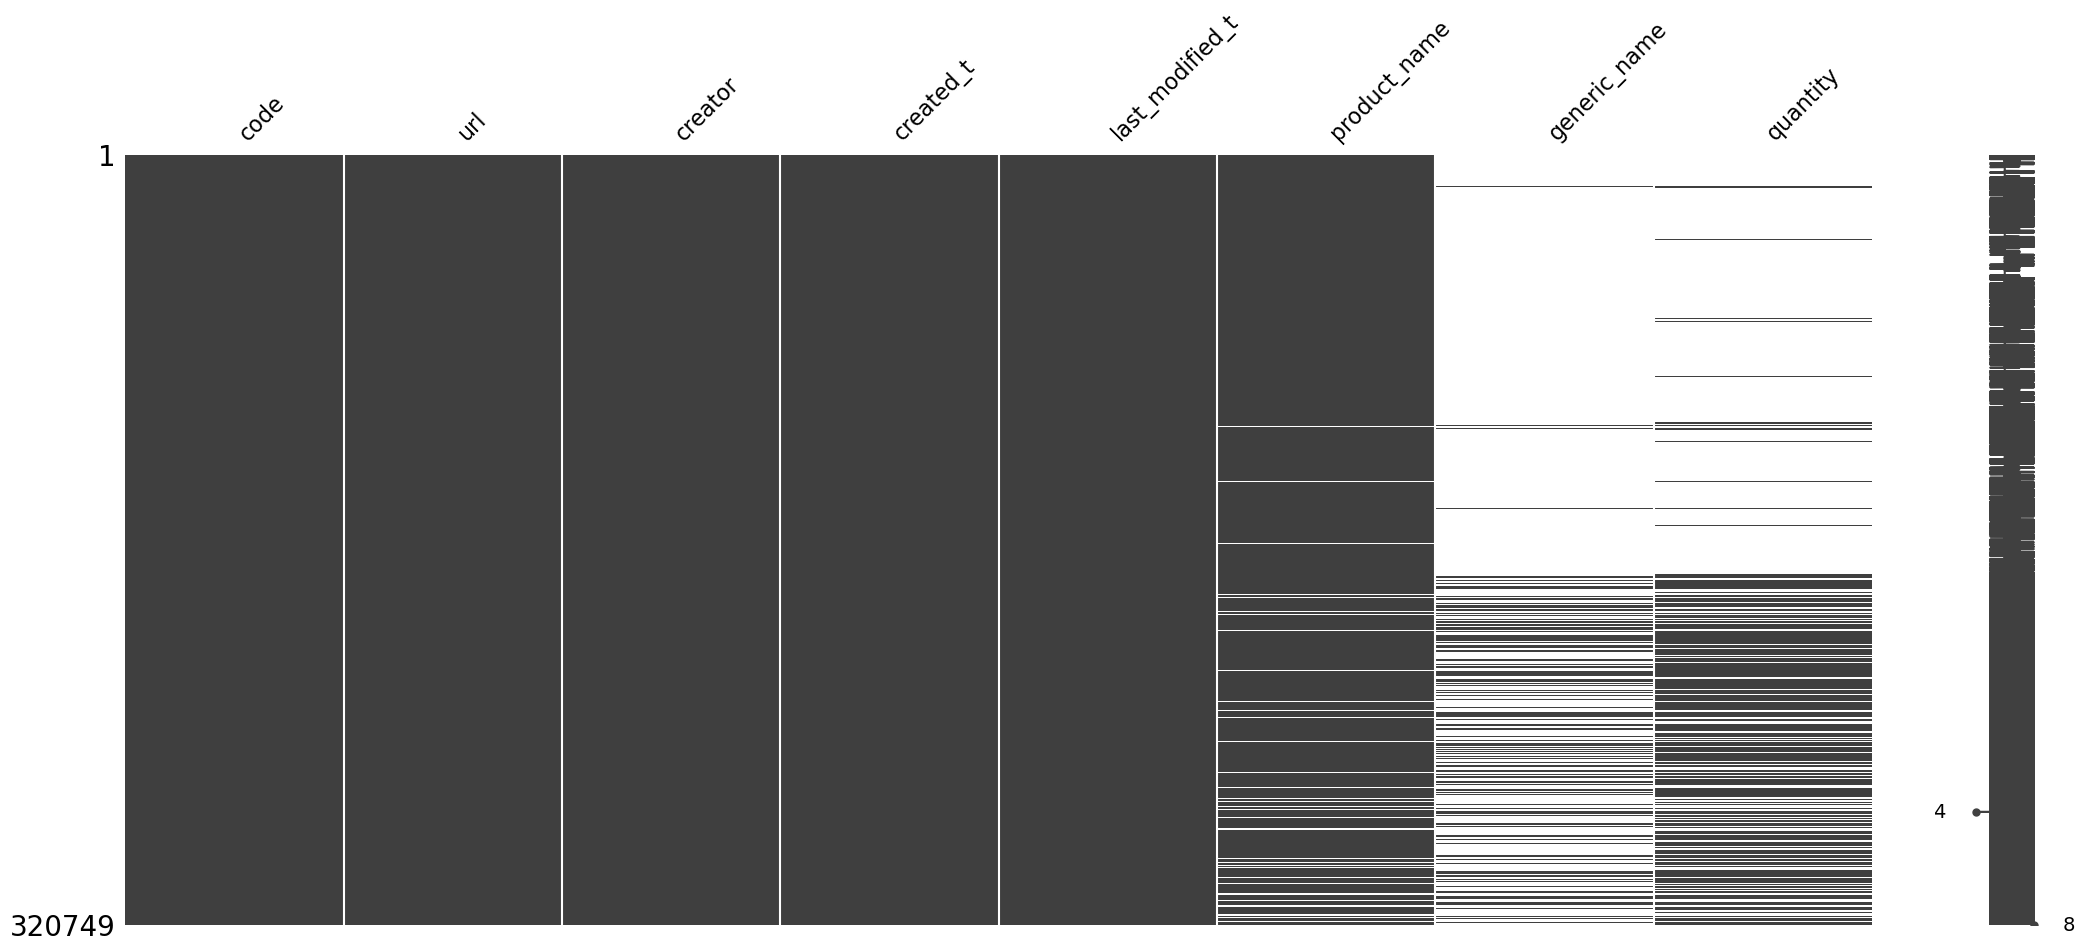

In [32]:
# les variables general_information
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(general_information)]]);

In [33]:
data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(general_information)]].isna().sum()/nbLigne

code               0.000000
url                0.000000
creator            0.000006
created_t          0.000000
last_modified_t    0.000000
product_name       0.055377
generic_name       0.835469
quantity           0.673265
dtype: float64

</br>

</br>

</br>

In [34]:
# general_information
col_to_drop += ['generic_name','url','creator', 'created_t', 'last_modified_t']
colgarder += ['code','product_name','quantity']

#Maj general_information
[general_information.remove(x) for x in col_to_drop]
general_information

['code', 'product_name', 'quantity']

</br>

</br>

</br>

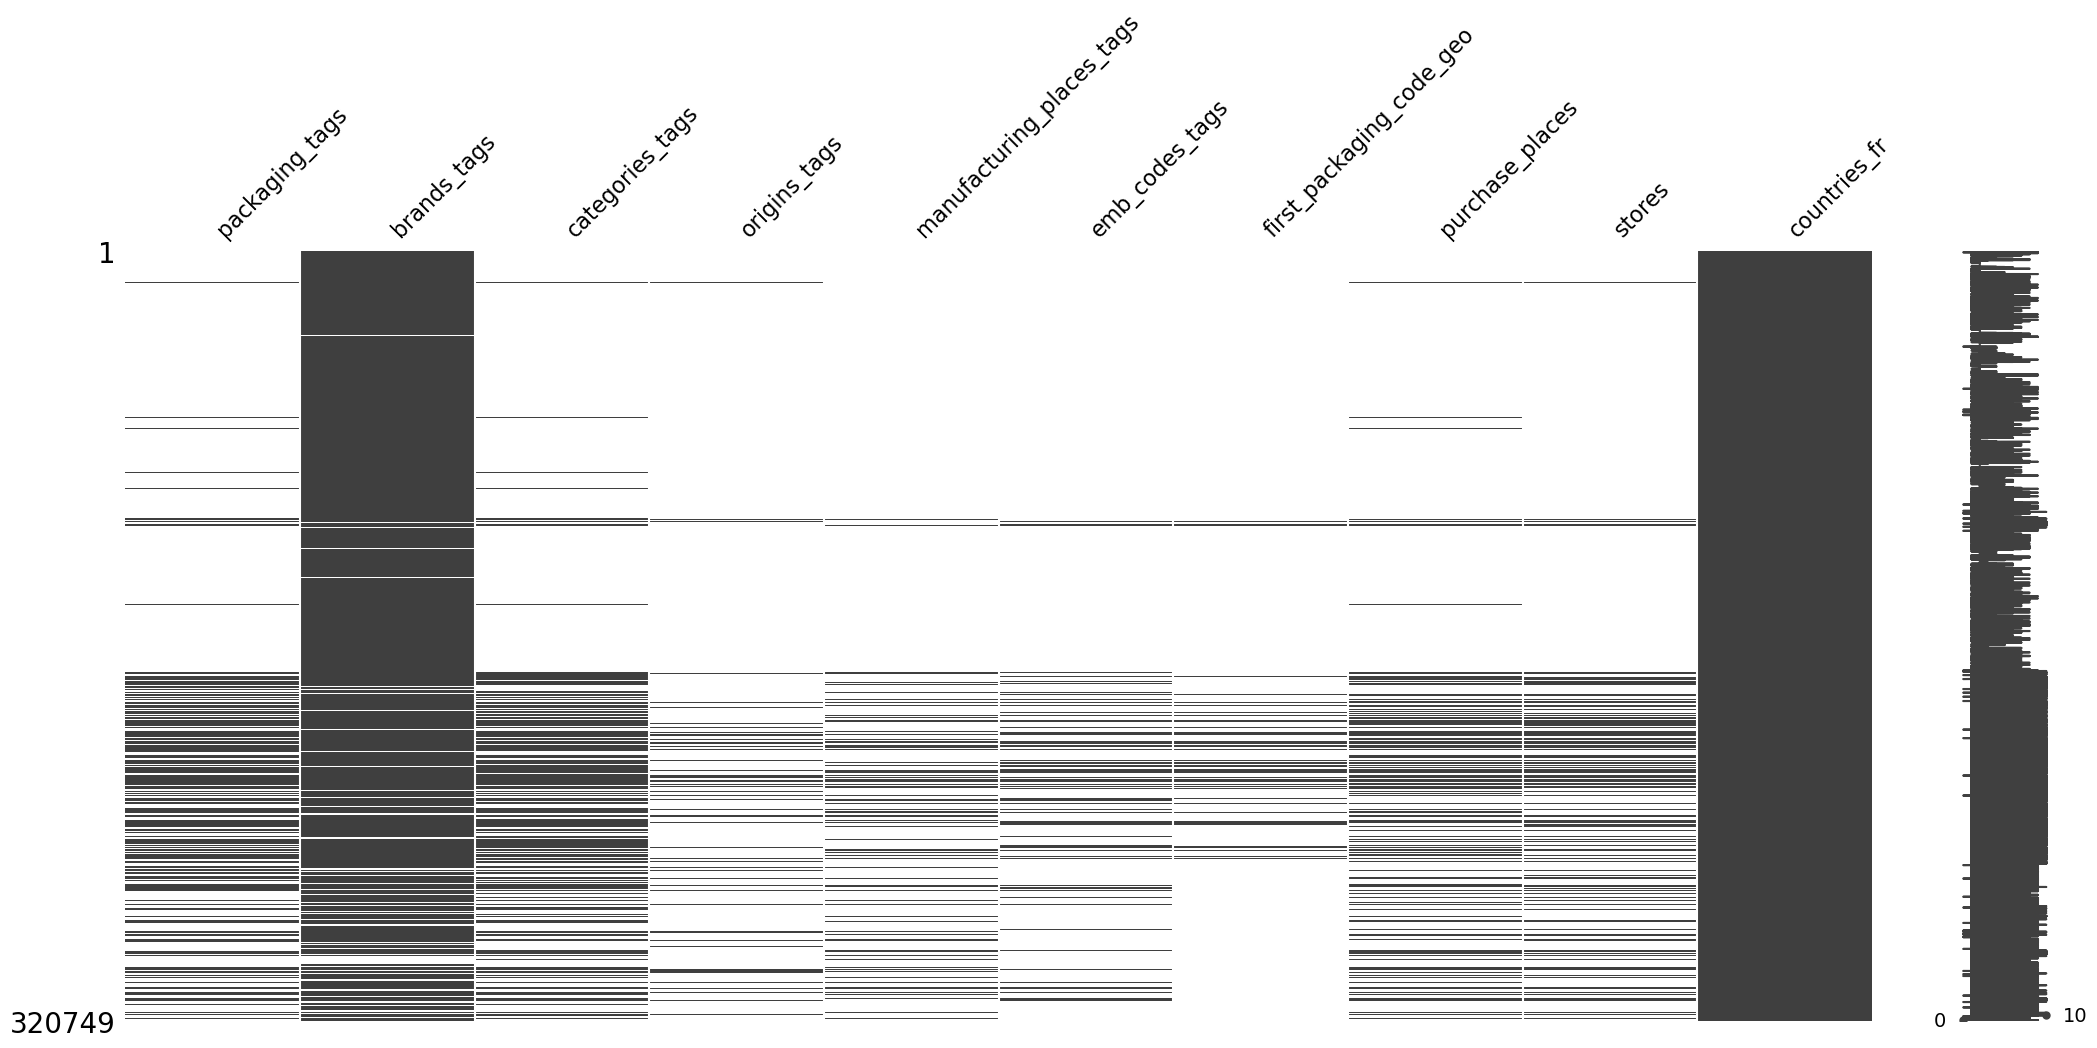

In [35]:
# les variables tags
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(tags)]]);

In [36]:
data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(tags)]].isna().sum()/nbLigne

packaging_tags               0.753823
brands_tags                  0.088533
categories_tags              0.736900
origins_tags                 0.931002
manufacturing_places_tags    0.886288
emb_codes_tags               0.908645
first_packaging_code_geo     0.941378
purchase_places              0.818643
stores                       0.838818
countries_fr                 0.000873
dtype: float64

categories_fr, main_categorie et categories_fr sont rempli de la meme façon.
Les produits ne possédant dinfos pour la variables categories ne possedent pas d'infos pour la variables main_category

In [37]:
# tags
col_to_drop += [ 'packaging_tags','brands_tags', 'categories_tags',
                'origins_tags','manufacturing_places_tags', 
                'emb_codes_tags','first_packaging_code_geo',
                'purchase_places','stores','countries_fr',
                #'cities',
                #'cities_tags','countries','countries_tags',
                #'emb_codes', 
                #'categories',
                 ]


#Maj tags
[tags.remove(x) for x in [ 'packaging_tags','brands_tags', 'categories_tags',
                'origins_tags','manufacturing_places_tags', 
                'emb_codes_tags','first_packaging_code_geo',
                'purchase_places','stores','countries_fr',]]
tags

[]

</br>

</br>

</br>

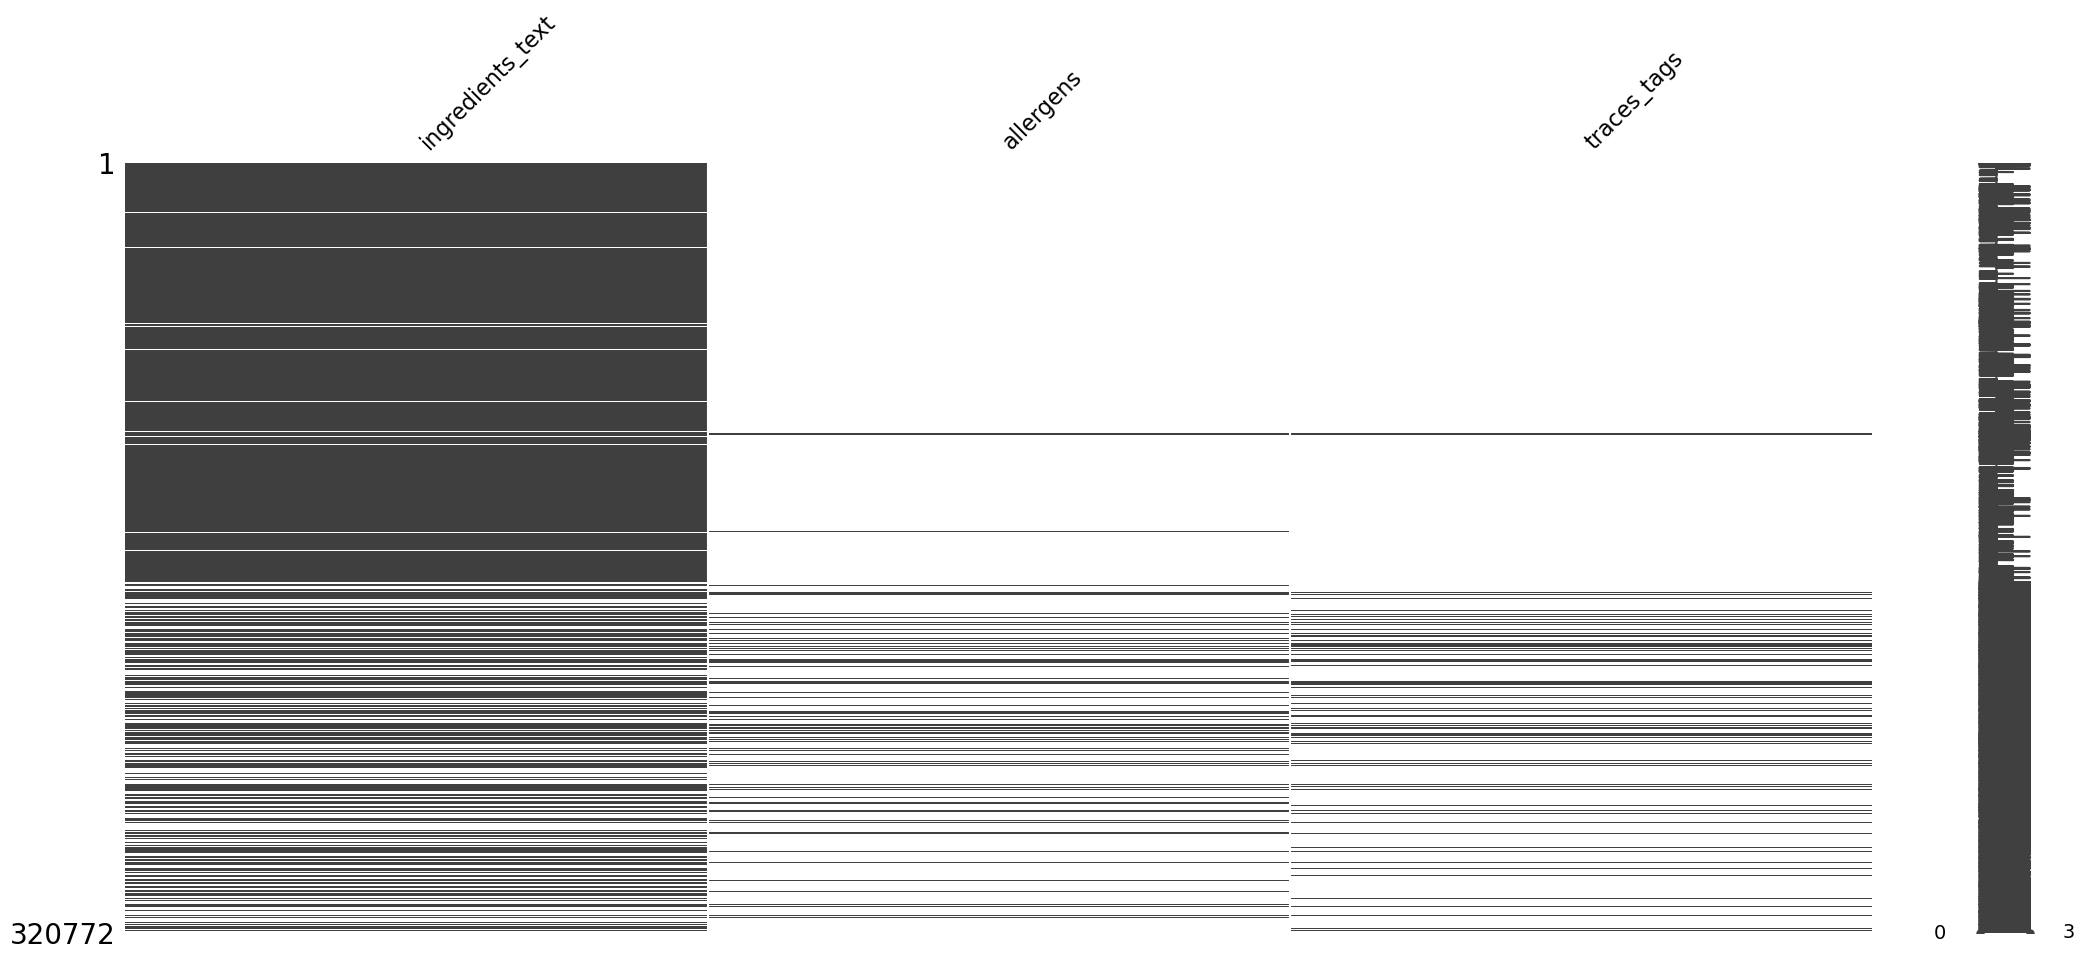

In [38]:
#les variables ingredients
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(ingredients)]]);

In [39]:
openfoodfacts[ingredients].notna().sum()/nbLigne

ingredients_text    0.776189
allergens           0.088368
traces_tags         0.075851
dtype: float64

In [40]:
# ingredients
col_to_drop += ['ingredients_text','allergens', 'traces_tags']
#colgarder += ['ingredients_text']

#Maj tags
[ingredients.remove(x) for x in [ 'ingredients_text','allergens', 'traces_tags']]
ingredients

[]

</br>

</br>

</br>

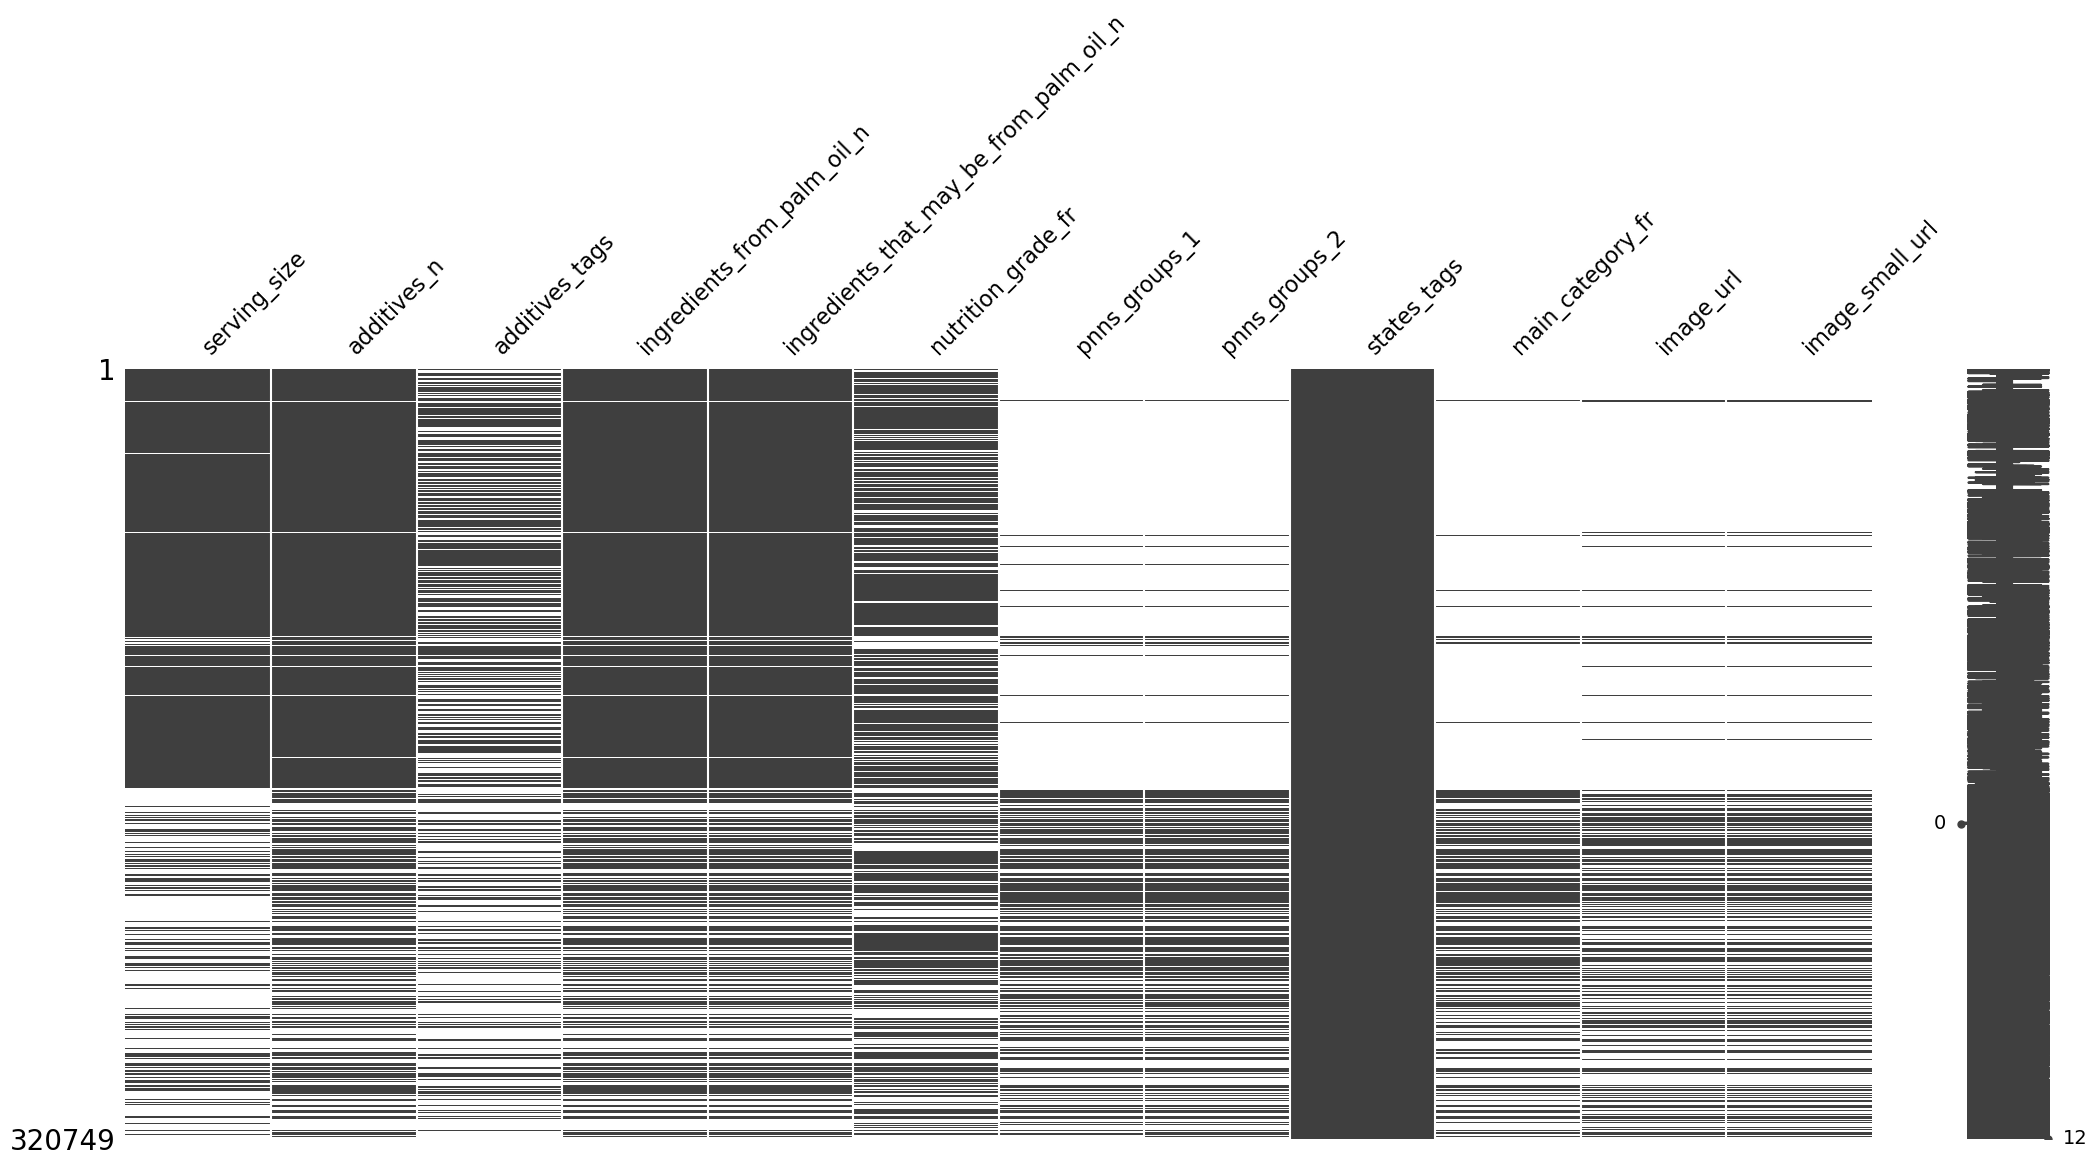

In [41]:
#les variables misc_data
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(misc_data)]]);

In [42]:
misc_data

['serving_size',
 'additives_n',
 'additives_tags',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states_tags',
 'main_category_fr',
 'image_url',
 'image_small_url']

In [43]:
pd.set_option('max_colwidth', -1)

C:\Users\eleor\AppData\Local\Temp\ipykernel_7812\3633274849.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [44]:
data_cleaned[['pnns_groups_1','pnns_groups_2']].notna().sum()/nbLigne

pnns_groups_1    0.285310
pnns_groups_2    0.294595
dtype: float64

In [45]:
data_cleaned[['pnns_groups_1','pnns_groups_2','main_category_fr']].describe()

,pnns_groups_1,pnns_groups_2,main_category_fr
count,91513,94491,84366
unique,14,42,3543
top,unknown,unknown,Boissons
freq,22624,22624,6054


In [46]:
data_cleaned[['pnns_groups_1','pnns_groups_2']].drop_duplicates().sort_values('pnns_groups_1')

,pnns_groups_1,pnns_groups_2
10316,Beverages,Artificially sweetened beverages
10358,Beverages,Fruit juices
65421,Beverages,Fruit nectars
226,Beverages,Sweetened beverages
188,Beverages,Non-sugared beverages
628,Cereals and potatoes,Cereals
9779,Cereals and potatoes,Breakfast cereals
23712,Cereals and potatoes,Potatoes
177,Cereals and potatoes,Bread
182,Cereals and potatoes,Legumes


In [47]:
# unknown
data_cleaned['pnns_groups_2'][data_cleaned['pnns_groups_2']=='unknown'] = np.nan
data_cleaned['pnns_groups_1'][data_cleaned['pnns_groups_1']=='unknown'] = np.nan

# remplacer les '-' par ' ' et transformer toutes valeurs en minuscules
data_cleaned.pnns_groups_2 = data_cleaned.pnns_groups_2.str.replace('-',' ',regex=True).str.lower()
data_cleaned.pnns_groups_1 = data_cleaned.pnns_groups_1.str.replace('-',' ',regex=True).str.lower()

C:\Users\eleor\AppData\Local\Temp\ipykernel_7812\2882977354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['pnns_groups_2'][data_cleaned['pnns_groups_2']=='unknown'] = np.nan
C:\Users\eleor\AppData\Local\Temp\ipykernel_7812\2882977354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['pnns_groups_1'][data_cleaned['pnns_groups_1']=='unknown'] = np.nan


In [48]:
# creation colonne "ingredients_from_palm_oil_nb"

In [49]:
# misc_data
col_to_drop += ['additives_tags','states_tags','image_url', 'image_small_url']


colgarder += ['serving_size','additives_n', 'ingredients_from_palm_oil_n',
              'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 
              'pnns_groups_1', 'pnns_groups_2', 'main_category_fr']

#Maj tags
[misc_data.remove(x) for x in ['additives_tags','states_tags','image_url', 'image_small_url']]
misc_data

['serving_size',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category_fr']

</br>

</br>

</br>

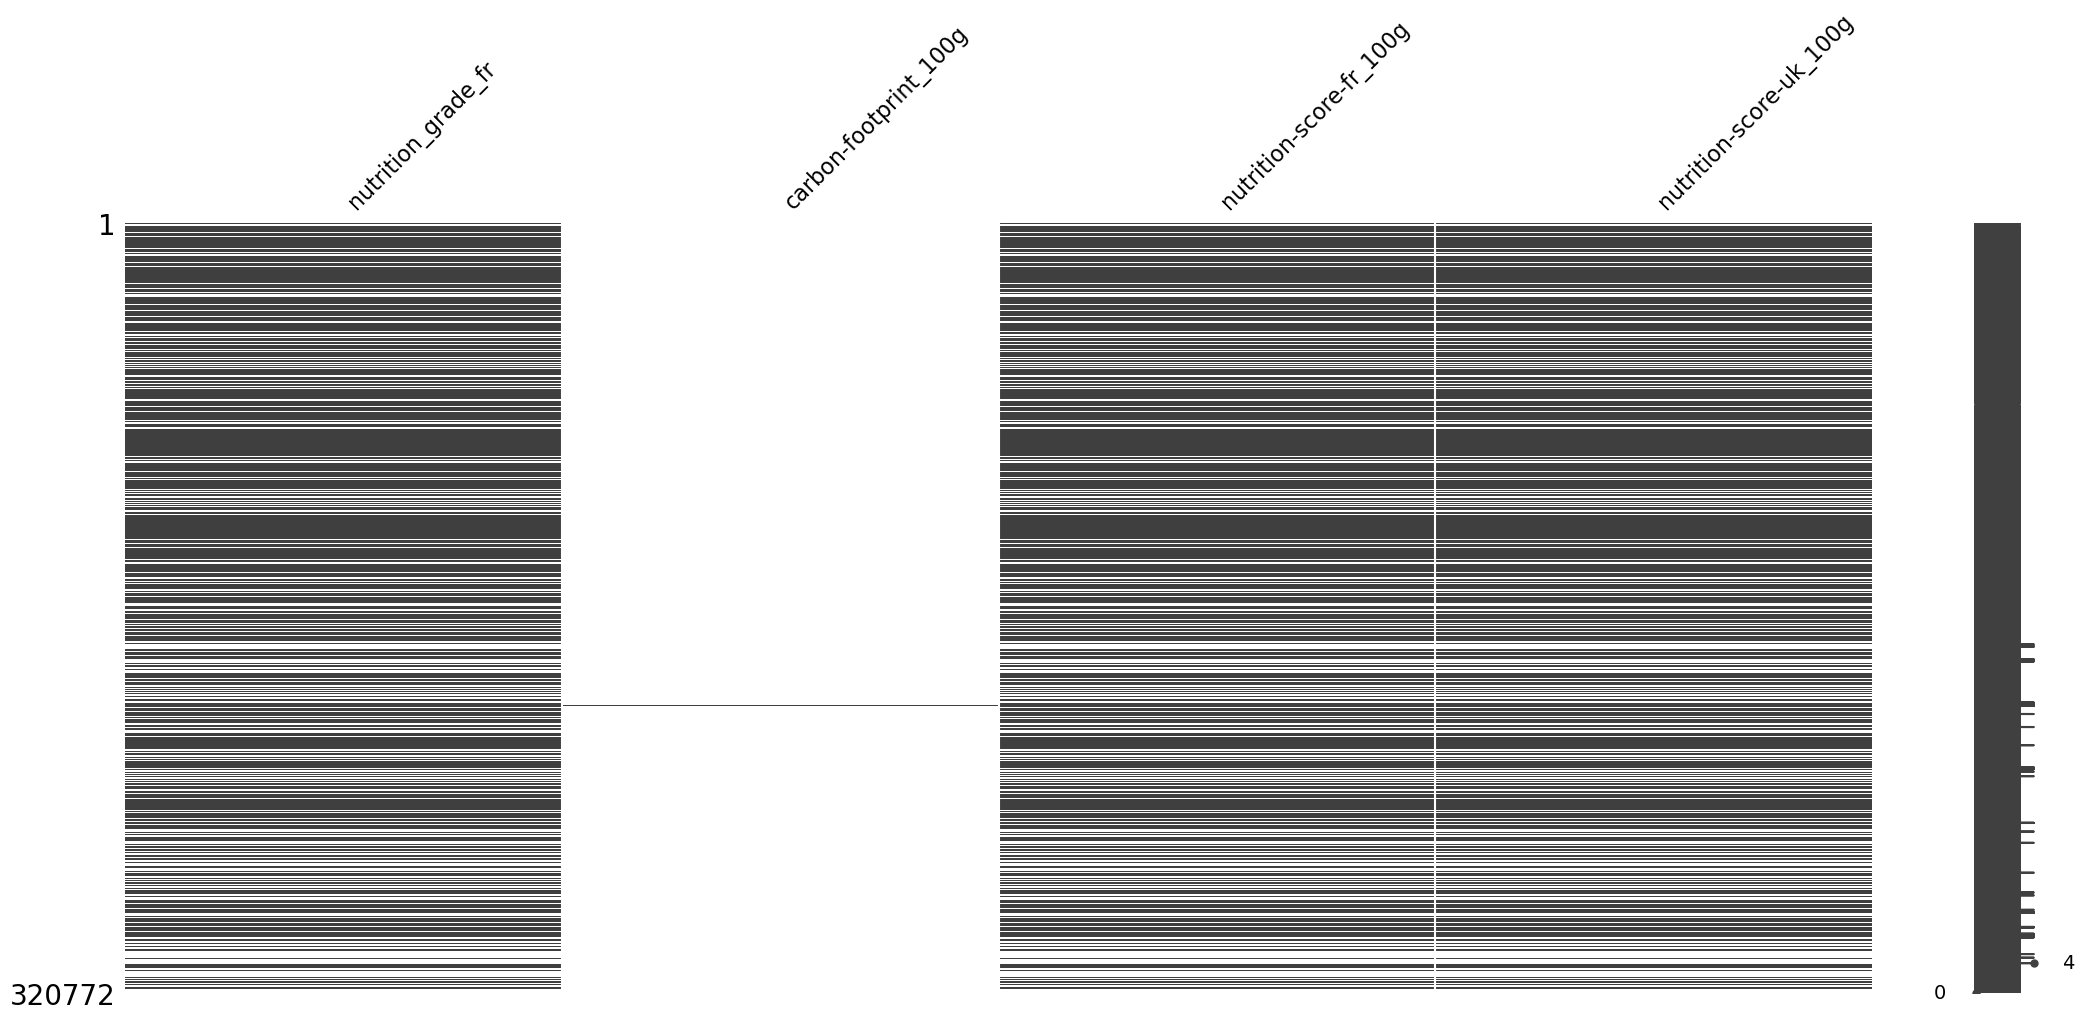

In [50]:
# les variables score_foot_print
msno.matrix(openfoodfacts.loc[:,data_cleaned.columns[data_cleaned.columns.isin(score_foot_print)]]);

In [51]:
data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(score_foot_print)]].isna().sum()/nbLigne

nutrition_grade_fr         0.310333
carbon-footprint_100g      0.999164
nutrition-score-fr_100g    0.310333
nutrition-score-uk_100g    0.310333
dtype: float64

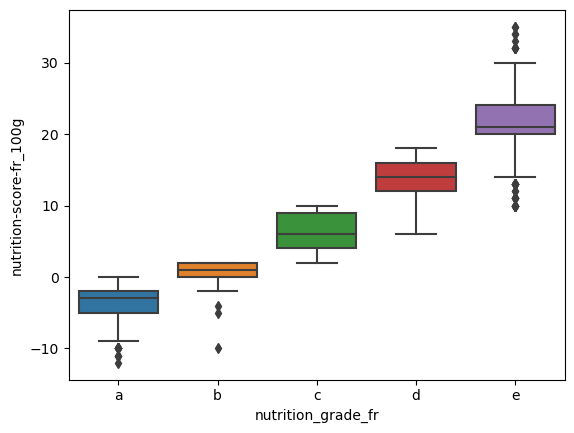

In [52]:
#data_cleaned[[ 'nutrition-score-fr_100g', 'data_cleaned.nutrition_grade_fr']].boxplot()
sns.boxplot(y='nutrition-score-fr_100g',
            x='nutrition_grade_fr',
            data=openfoodfacts.sample(10000).sort_values(by='nutrition_grade_fr'));

In [53]:
# score_foot_print
col_to_drop += ['nutrition_grade_uk','carbon-footprint_100g', 'nutrition-score-uk_100g']

colgarder += ['nutrition_grade_fr', 'nutrition-score-fr_100g']

#Maj tags
[score_foot_print.remove(x) for x in ['nutrition_grade_uk','carbon-footprint_100g', 'nutrition-score-uk_100g']]
score_foot_print

['nutrition_grade_fr', 'nutrition-score-fr_100g']

</br>

</br>

</br>

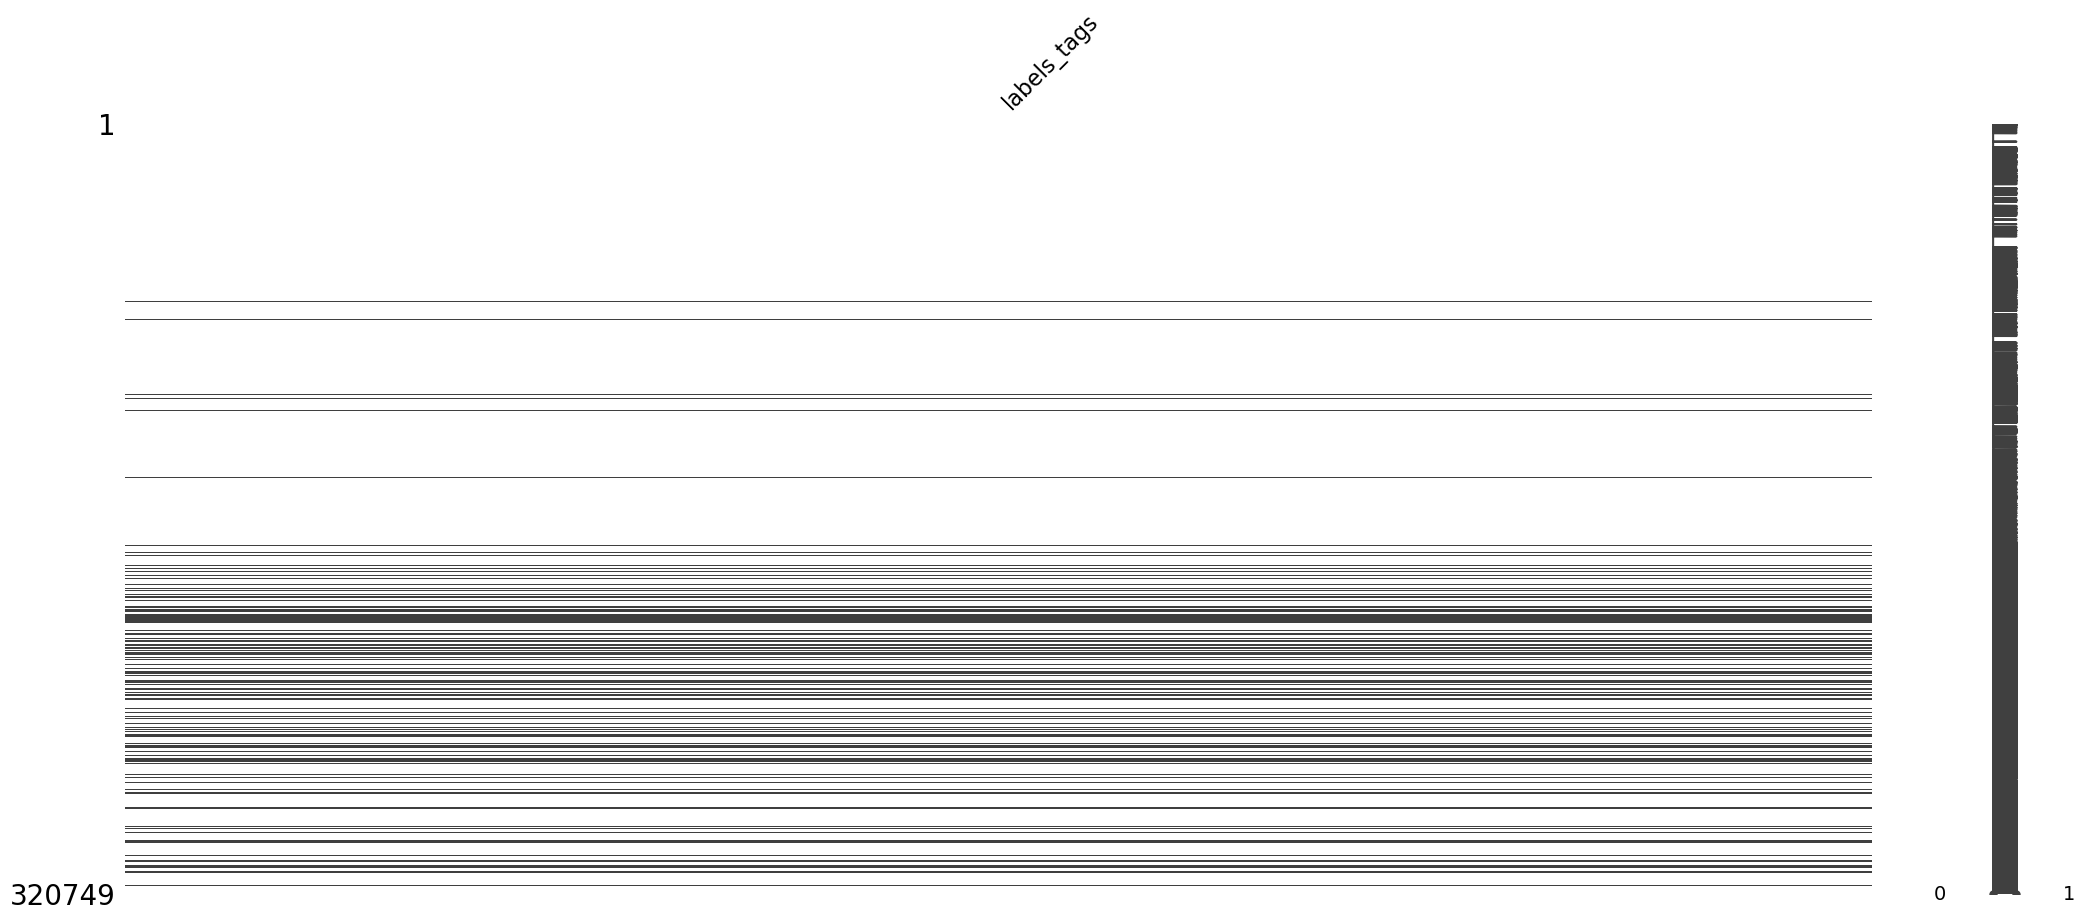

In [54]:
# les variables score_foot_print
msno.matrix(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(labels)]]);

In [55]:
data_cleaned[data_cleaned.labels_tags.notna()][data_cleaned.columns[data_cleaned.columns.isin(labels)]].sample(5)

,labels_tags
212378,en:green-dot
195478,"en:green-dot,en:made-in-france,fr:eco-emballages,fr:herta-s-engage,fr:nutritional-compass"
248115,"en:low-or-no-sugar,en:green-dot,en:no-added-sugar"
251443,"en:organic,en:eu-organic,fr:ab-agriculture-biologique"
176549,"en:halal,en:hazard-analysis-and-critical-control-points,en:brc,en:iso"


In [56]:
data_cleaned[data_cleaned.labels_tags.notna()][data_cleaned.columns[data_cleaned.columns.isin(labels)]].describe()

,labels_tags
count,46644
unique,13653
top,"en:organic,en:eu-organic,fr:ab-agriculture-biologique"
freq,5311


In [57]:
data_cleaned['presenceDeLabels'] = data_cleaned.labels_tags.notna()*1


# MAJ du DF nomColonnes
nomColonnes = pd.concat([nomColonnes,pd.DataFrame({'Colonnes':'presenceDeLabels',
                                                   'type_de_colonne':'score_foot_print',
                                                   'Nombre de valeurs manquantes':data_cleaned.presenceDeLabels.isna().sum()},
                                                 index = [data_cleaned.presenceDeLabels.isna().sum()])], 
                        axis=0)

In [58]:
# labels

# Variables à supprimer
col_to_drop += ['labels_tags']

# Variables à conserver
colgarder += ['presenceDeLabels']



#Maj tags
labels = ['presenceDeLabels']
labels

['presenceDeLabels']

</br>

</br>

</br>

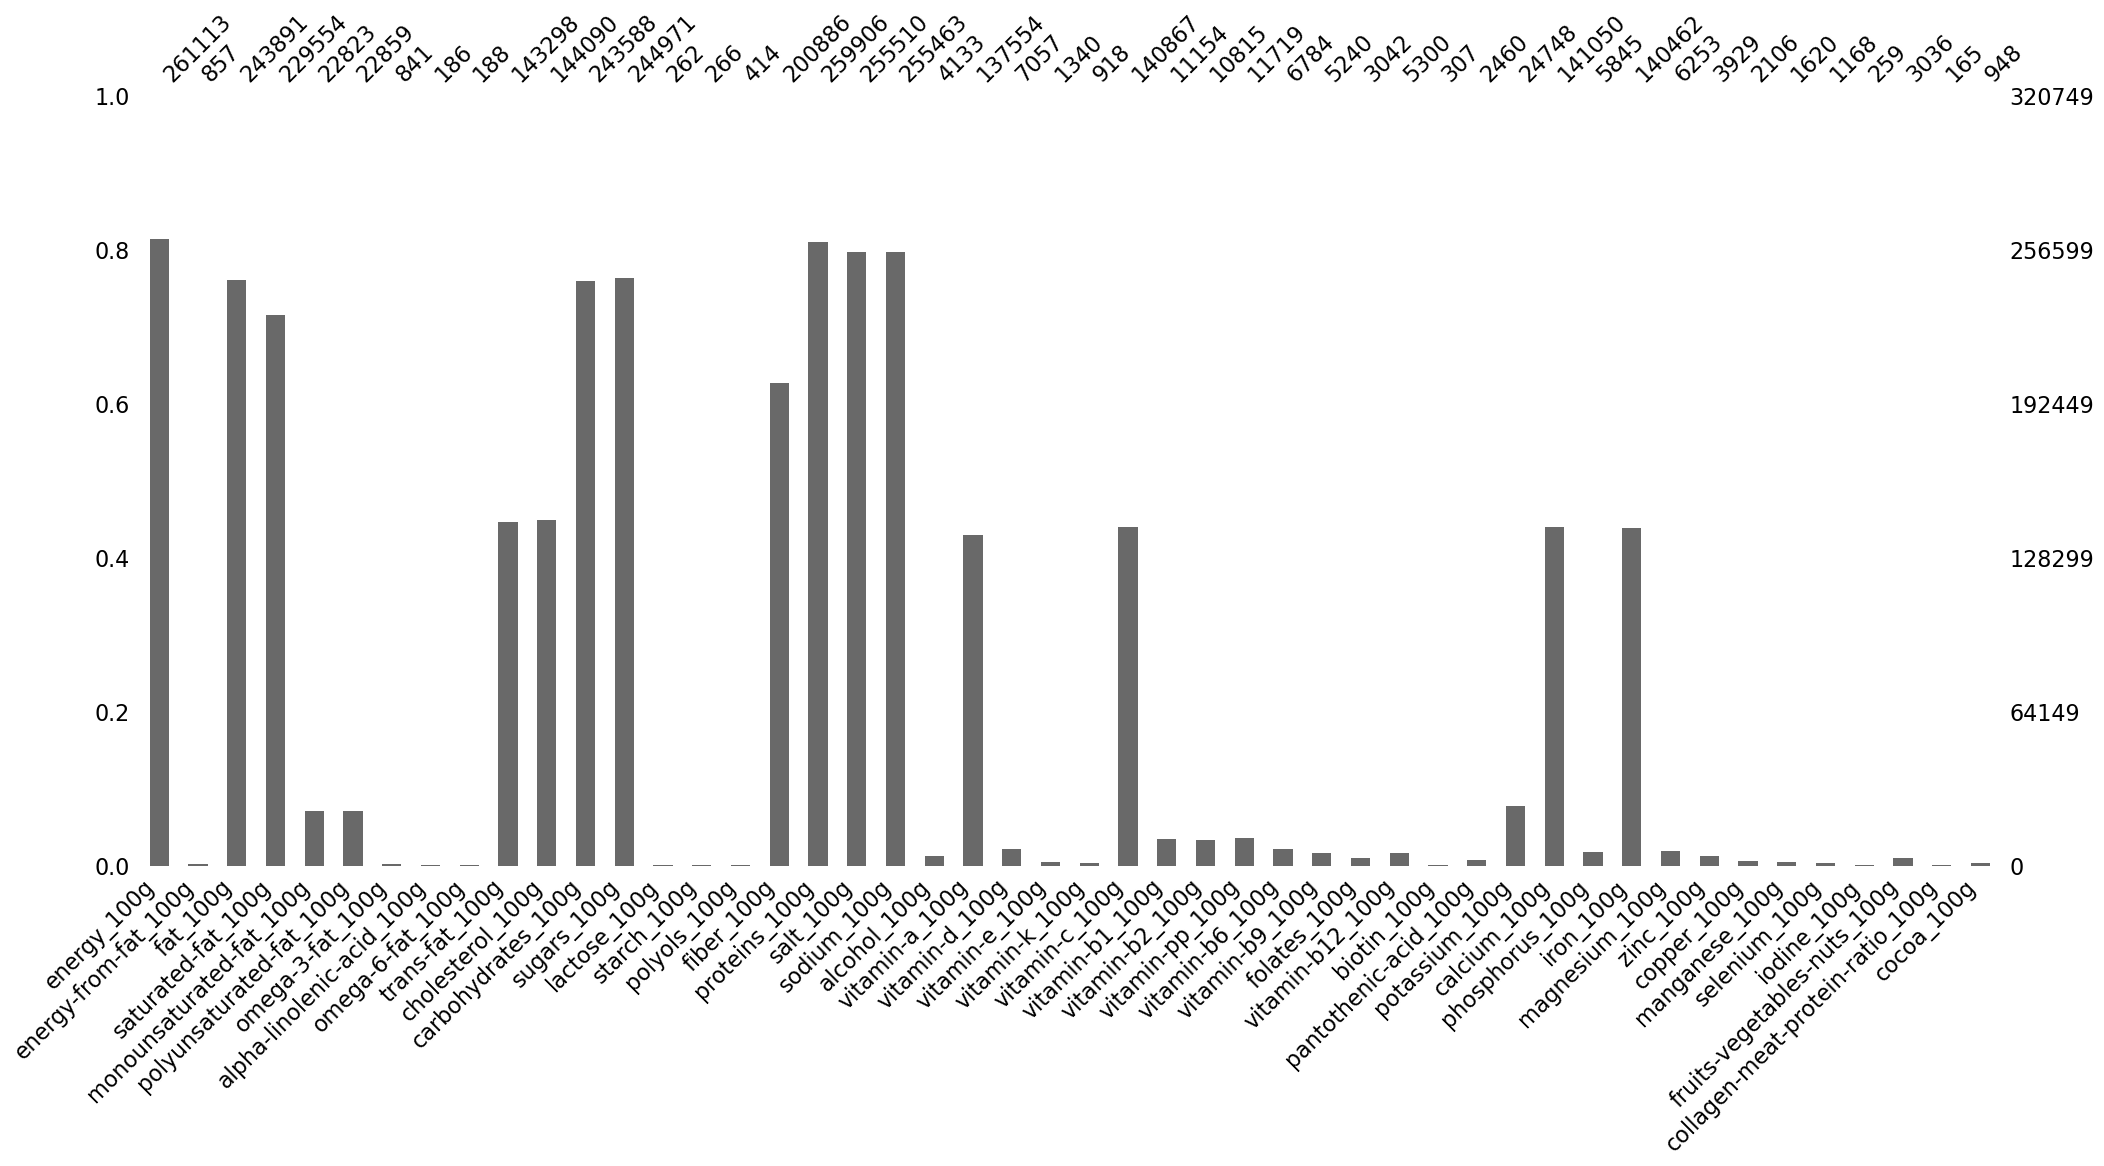

In [59]:
# nutrition_facts
msno.bar(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(nutrition_facts)] ]);

In [60]:
pd.DataFrame(data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(nutrition_facts)] ].isna().sum()/nbLigne).T\
.style.background_gradient(cmap='Blues').format("{:.2%}")

,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,omega-6-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,potassium_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g
0,18.59%,99.73%,23.96%,28.43%,92.88%,92.87%,99.74%,99.94%,99.94%,55.32%,55.08%,24.06%,23.63%,99.92%,99.92%,99.87%,37.37%,18.97%,20.34%,20.35%,98.71%,57.11%,97.80%,99.58%,99.71%,56.08%,96.52%,96.63%,96.35%,97.88%,98.37%,99.05%,98.35%,99.90%,99.23%,92.28%,56.02%,98.18%,56.21%,98.05%,98.78%,99.34%,99.49%,99.64%,99.92%,99.05%,99.95%,99.70%


In [61]:
nomColonnes

,Colonnes,type_de_colonne,Taux de valeurs non nulles,Nombre de valeurs manquantes
0,code,general_information,100.00,0
1,url,general_information,100.00,0
2,creator,general_information,100.00,2
3,created_t,general_information,100.00,0
4,last_modified_t,general_information,100.00,0
5,product_name,general_information,94.46,17762
6,generic_name,general_information,16.45,267976
7,quantity,general_information,32.67,215949
8,packaging_tags,tags,24.62,241788
9,brands_tags,tags,91.15,28397


Au total le jeu de données contient 48 colonnes contenant des informations sur les valeurs nutritives. 
Parmi ces colonnes, 33 sont composées de plus de 60% de valeurs manquantes


''

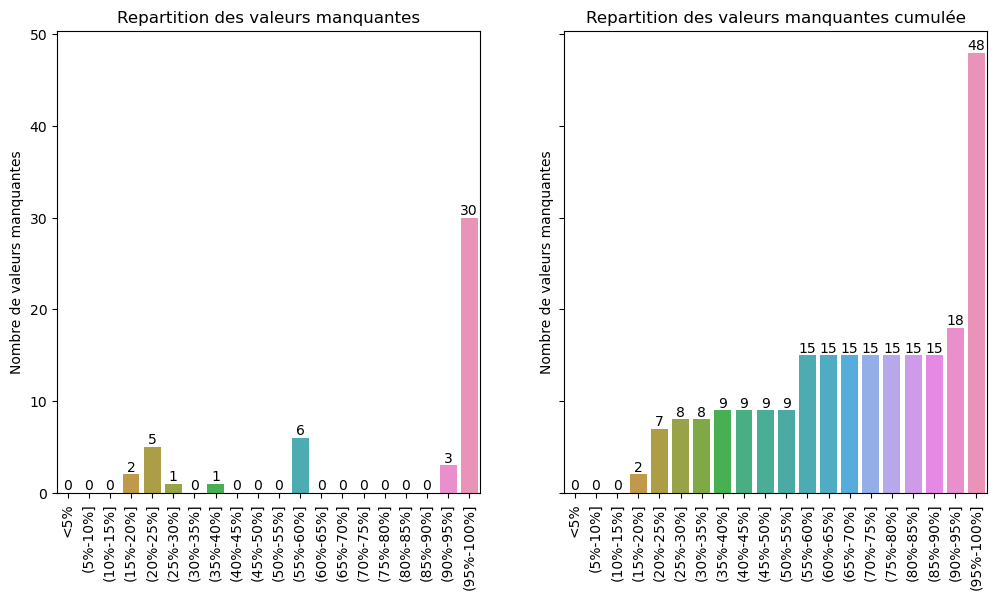

In [62]:
thresold = 0.6
print('Au total le jeu de données contient {} colonnes contenant des informations sur les valeurs nutritives. \nParmi ces colonnes, {} sont composées de plus de {pourc:.0%} de valeurs manquantes'
      .format((nomColonnes.type_de_colonne=='nutrition_facts').sum(),
              (data_cleaned.loc[:,data_cleaned.columns[data_cleaned.columns.isin(nutrition_facts)] ].isna().sum()>=nbLigne*thresold).sum(),pourc=thresold
              ))

nbin = 20
interbin = 100/nbin

xlab = ['<{:.0f}%'.format(interbin) if i==0 else '({:.0f}%-{:.0f}%]'.format(i*interbin,(i+1)*interbin) for i in range(nbin)]
ycut = pd.cut(nomColonnes[nomColonnes.type_de_colonne=='nutrition_facts']['Nombre de valeurs manquantes']/nbLigne, 
                     [ i/nbin for i in range(nbin+1)], # ajoute 1 pour obtenir la derniere tranche
                     include_lowest=False).value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

axes[0].set_title('Repartition des valeurs manquantes')
sns.barplot(x=ycut.index, y=ycut,ax=axes[0] )
axes[0].set_xticks(range(nbin))   # Attention cette fois on ajoute pas +1
axes[0].set_xticklabels(xlab, rotation=90)
axes[0].bar_label(axes[0].containers[0])

axes[1].set_title('Repartition des valeurs manquantes cumulée')
sns.barplot(x=ycut.index, y=ycut.cumsum(),ax=axes[1] )
axes[1].set_xticks(range(nbin))# Attention cette fois on ajoute pas +1
axes[1].set_xticklabels(xlab, rotation=90)
axes[1].bar_label(axes[1].containers[0])

;

''

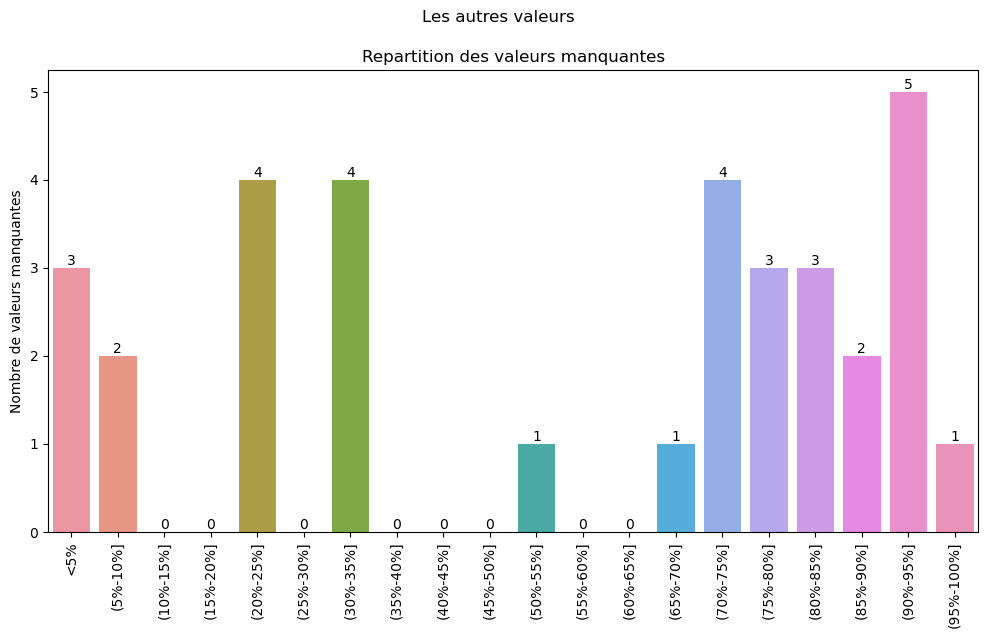

In [63]:
ytotcut = pd.cut(nomColonnes[nomColonnes.type_de_colonne!='nutrition_facts']['Nombre de valeurs manquantes']/nbLigne, 
                     [ i/nbin for i in range(nbin+1)], # ajoute 1 pour obtenir la derniere tranche
                     include_lowest=False).value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 6))

fig.suptitle('Les autres valeurs')
axes.set_title('Repartition des valeurs manquantes')
sns.barplot(x=ytotcut.index, y=ytotcut,ax=axes )
axes.set_xticks(range(nbin))   # Attention cette fois on ajoute pas +1
axes.set_xticklabels(xlab, rotation=90)
axes.bar_label(axes.containers[0])

;

In [64]:
# nutrition_facts

print('le seuil ',thresold)
for col,typc,nNa in zip(nomColonnes.Colonnes,
                        nomColonnes.type_de_colonne,
                        nomColonnes['Nombre de valeurs manquantes']) :
    if typc =='nutrition_facts':
        if nNa >= (nbLigne * thresold): # suppr col qui possèdent 95% de valeurs nulles
            col_to_drop.append(col)
        else:
            colgarder.append(col)

le seuil  0.6


In [65]:
colgarder

['code',
 'product_name',
 'quantity',
 'serving_size',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category_fr',
 'nutrition_grade_fr',
 'nutrition-score-fr_100g',
 'presenceDeLabels',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g']

In [66]:
print('Parmi les {} colonnes, nous en supprimons {} et gardons {}'.format(nbCol,len(col_to_drop),len(colgarder) ) )

Parmi les 85 colonnes, nous en supprimons 59 et gardons 29


</br>

In [67]:
colgarder

['code',
 'product_name',
 'quantity',
 'serving_size',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category_fr',
 'nutrition_grade_fr',
 'nutrition-score-fr_100g',
 'presenceDeLabels',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'vitamin-a_100g',
 'vitamin-c_100g',
 'calcium_100g',
 'iron_100g']

In [68]:
# A-t-on oublié certaines colonnes
[x  for x in data_cleaned.columns if x not in col_to_drop+colgarder ]

[]

In [ ]:
data_cleaned.serving_size.dtypes

In [ ]:
etude_test = data_cleaned[data_cleaned.columns[(~data_cleaned.columns.isin(nutrition_facts)) & (data_cleaned.columns.isin(colgarder))]]\
.drop(columns=['code','product_name','categories_fr','main_category_fr'])

In [ ]:
etude_test.columns

In [ ]:
sns.pairplot(etude_test, hue="nutrition_grade_fr")

In [ ]:
data_cleaned[colgarder].corr().style.background_gradient(cmap='Blues').format("{:.2%}")

In [ ]:
etude_test.serving_size[etude_test.serving_size.notna()].str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).value_counts().index[:5].to_list()+etude_test.quantity[etude_test.quantity.notna()].str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).value_counts().index[:10].to_list()

In [ ]:
data_cleaned[['quantity','url','serving_size']][etude_test.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True)=='xg'].sample(10)

In [ ]:
unites = {
    #les liquides
    'l' : 'litre', 'ml': 'litre', 'cl': 'litre', 'litre': 'litre','litres': 'litre',
    'floz': 'litre', 'xcl':'litre','xml': 'litre', 'g/ml':'litre', 'le':'litre',
    
    # les aliments solides (ou mous)
    'kg': 'poids','g' : 'poids', 'gr': 'poids', 'oz': 'poids', 'xg': 'poids',  'ge': 'poids',
    'grammes': 'poids','г': 'poids',  'xg=g': 'poids', 'ozg': 'poids', 'grs': 'poids', 'lb': 'poids',
    
    # ceux qui peuvent etre definis
    'kg[x]': 'petit pot/yaourt', 'gml': 'bocal/conserve', 'mlg':'creme/sauce',
    
    # part ou portion de ensemble plus grand
    'sachets': 'unité','oeufs': 'unité','tranches': 'unité','x': 'unité',
    
}

unitesAbb = [
    #les liquides
    'l' , 'ml', 'cl', 'litre','litres', 'floz', 'xcl','xml', 'g/ml', 'le',
    
    # les aliments solides (ou mous)
    'kg','g' , 'gr', 'oz', 'xg',  'ge', 'grammes','г',  'xg=g', 'ozg', 'grs', 'lb',
    
    # ceux qui peuvent etre definis
    'kg[x]', 'gml', 'mlg',
    
    # part ou portion de ensemble plus grand
    'sachets','oeufs','tranches','x'
]

In [ ]:
#creation colonnes unites mini
data_cleaned['unites_abb'] = [y if y in unitesAbb else x if x in unitesAbb else np.nan for x,y in zip(data_cleaned.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True),
                    data_cleaned.serving_size.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True) )]

#creation colonnes unites
data_cleaned['unites'] = [y if not y is np.nan else x for x,y in zip(data_cleaned.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).map(unites),
                    data_cleaned.serving_size.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).map(unites))]

In [ ]:
data_cleaned['unites_abb'].value_counts().plot(kind='bar')

In [ ]:
data_cleaned['unites'].value_counts().plot(kind='bar')

In [ ]:
# get dummies
data_cleaned[['bocal/conserve','creme/sauce','litre','petit pot/yaourt','poids','unité']] = pd.get_dummies(data_cleaned.unites)

In [ ]:
colgarder += ['bocal/conserve','creme/sauce','litre','petit pot/yaourt','poids','unité']

</br>

</br>

## Gestion des outliers

#### les boxplots

In [ ]:
imp = 0
fig,axes = plt.subplots(nrows = 20,ncols = 1,figsize=(10,60))
for i,col in enumerate( colgarder ):
    if data_cleaned[col].dtypes in ['float64','int32']:
        sns.boxplot(x= 'nutrition_grade_fr', y= col,data = data_cleaned,ax=axes[i-imp],showmeans=True)
        axes.flatten()[i-imp].set_title(col)
    else:
        imp += 1
    

In [ ]:
ttt = [colgarder[i] for i,colk in enumerate(colgarder)  if colk not in  ['nutrition_grade_fr','code', 'product_name', 'quantity', 'categories_fr','main_category_fr'] ]
data_cleaned[ttt].boxplot(rot=90,figsize = (20,10))
del ttt;

</br>

</br>

In [ ]:
openfoodfacts[data_cleaned.energy_100g>=325137.3][['nutrition_grade_fr','url','code', 'product_name', 'quantity', 'categories_fr','main_category_fr','energy_100g']]


In [ ]:
data_cleaned.energy_100g.describe()

In [ ]:
data_cleaned.loc[data_cleaned.code=='3257983143096','energy_100g'] = 1373
data_cleaned.loc[data_cleaned.code=='8710573641501','energy_100g'] = 2312
data_cleaned.loc[data_cleaned.code=='3661405001053','energy_100g'] = 764
data_cleaned.loc[data_cleaned.code=='0201203040026','energy_100g'] = 3700
data_cleaned.loc[data_cleaned.code=='0619309100979','energy_100g'] = 92

In [ ]:
nomColonnes[nomColonnes.Colonnes == 'salt_100g']

In [ ]:
ttt = [colgarder[i] for i,colk in enumerate(colgarder)  if (colk not in  ['nutrition-score-fr_100g','energy_100g','nutrition_grade_fr']) & (colk in nutrition_facts)]


for col in ttt:
    print(col)
    openfoodfacts.loc[openfoodfacts[col]>100,col] = np.nan
del ttt

In [ ]:
ttt = [colgarder[i] for i,colk in enumerate(colgarder)  if colk not in  ['energy_100g','nutrition_grade_fr','code', 'product_name', 'quantity', 'categories_fr','main_category_fr'] ]
openfoodfacts[ttt].boxplot(rot=90,figsize = (20,10),showfliers=True)
del ttt;

In [ ]:
#On peut voir que la repartitions des données va de 0g à 120g pour une portion de tranche de 100g

In [ ]:
## Autres anomalies detectées, les valeurs négatives

In [ ]:
openfoodfacts[openfoodfacts.columns[openfoodfacts.columns.isin(colgarder) & openfoodfacts.columns.isin(openfoodfacts.dtypes[openfoodfacts.dtypes!=object].index.to_list())]].apply(lambda x : x<0).sum()

In [ ]:
for col in ['iron_100g','vitamin-c_100g','vitamin-a_100g','sugars_100g','fiber_100g' ,'proteins_100g','trans-fat_100g']:
    print(col ,'| ',openfoodfacts.loc[openfoodfacts[col]<0,'url'].values[0],' | ',openfoodfacts.loc[openfoodfacts[col]<0,col].values[0])

In [ ]:
for col in ['iron_100g','vitamin-c_100g','vitamin-a_100g','sugars_100g','fiber_100g' ,'proteins_100g','trans-fat_100g']:
    openfoodfacts.loc[openfoodfacts[col]<0,col]=np.nan

In [ ]:
ttt = [colgarder[i] for i,colk in enumerate(colgarder)  if colk not in  ['energy_100g','nutrition_grade_fr','code', 'product_name', 'quantity', 'categories_fr','main_category_fr'] ]
openfoodfacts[ttt].boxplot(rot=90,figsize = (20,10),showfliers=True)
del ttt;

In [ ]:
nutrition_facts

In [ ]:
pd.options.display.max_rows=100
openfoodfacts[nutrition_facts].apply(lambda x: x.quantile(q=0.75) - x.quantile(q=0.25)).T

## Gestions des valeurs manquantes

In [ ]:
pd.set_option('max_colwidth',-1)

In [ ]:
#fillna

# nutrition_facts
openfoodfacts[nutrition_facts] = openfoodfacts[nutrition_facts].fillna(0,inplace=False)

In [ ]:

for i in nutrition_facts[:10]:
    openfoodfacts[[i]+['nutrition_grade_fr']].boxplot(by='nutrition_grade_fr', 
                                                                       column=i, 
                                                                       grid=False)

In [ ]:
#Ci dessous la liste des colonnes que l'on garde

In [ ]:
pd.options.display.max_rows=80
pd.DataFrame(openfoodfacts[openfoodfacts.columns[~openfoodfacts.columns.isin(nomColonnes.Colonnes[nomColonnes.type_de_colonne=='nutrition_facts'])]].notna().sum()/nbLigne)\
.style.background_gradient(cmap='Blues').format("{:.2%}")

## Creation dataframe etude

In [ ]:
df_openfoodfacts = openfoodfacts[colgarder]

if not os.path.exists('df_openfoodfacts.csv'):
    df_openfoodfacts.to_csv('df_openfoodfacts.csv',sep='\t',encoding='utf-8',index=False)

In [ ]:
#elargir la taille de la cellule
pd.set_option('max_colwidth', -1)

In [ ]:
openfoodfacts.loc[openfoodfacts.quantity.isna() & openfoodfacts.serving_size.notna()][['product_name','url','quantity','categories_fr','serving_size','additives_n','main_category_fr']]\
.sample(5)

In [ ]:
pd.DataFrame({'quantservcomp':[quant if not quant is np.nan else serv for quant,serv in zip(openfoodfacts.quantity,openfoodfacts.serving_size) ]}).isna().sum()/nbLigne

In [ ]:
openfoodfacts.ingredients_text.sample(5).str.split(',', expand=True)

In [ ]:
openfoodfacts[["main_category_fr",'categories_fr']].describe()

In [ ]:
#supprimer element entre parenthèse
(?<!m)

In [ ]:
openfoodfacts.ingredients_text[297693]

In [ ]:
openfoodfacts.ingredients_text.str.lower().replace('\\(   .+   (  ?<!\\(  )  \\)','',regex=True)[297693]

In [ ]:
openfoodfacts.ingredients_text.str\
.lower().str\
.replace('\\([^(]+\\)','',regex=True).str\
.split(',', expand=True).iloc[:,0].str\
.replace('organic','').str\
.replace('^ ','').describe()


In [ ]:
pd.options.display.max_rows=60

In [ ]:
openfoodfacts.columns[~openfoodfacts.columns.isin(nutrition_facts)].to_list()

In [ ]:
msno.matrix(df_openfoodfacts[df_openfoodfacts.columns[~df_openfoodfacts.columns.isin(nutrition_facts)].to_list()])

In [ ]:
msno.heatmap(df_openfoodfacts[['quantity','serving_size']])

</br>

</br>

</br>

### Supprimer les colonnes qui possèdent beaucoups de valeurs non nulles

In [ ]:
# Le % de valeurs manquantes et les colonnes à conserver
nomColonnes["%Na"] = nomColonnes['Nombre de valeurs manquantes']/nbLigne
nomColonnes["NoNa"] = (nbLigne - nomColonnes['Nombre de valeurs manquantes'])
nomColonnes["colASupp"] = nomColonnes.Colonnes.isin(col_to_drop)

In [ ]:
nomColonnes.colASupp[nomColonnes['Nombre de valeurs manquantes'] > (nbLigne * 0.95)] = True

In [ ]:
for x in nomColonnes.Colonnes[(nomColonnes.type_de_colonne=='nutrition_facts') & (nomColonnes.colASupp == True)]:
    nutrition_facts.remove(x)

In [ ]:
for nut in nutrition_facts:
    if nut in nomColonnes.Colonnes[(nomColonnes.type_de_colonne=='nutrition_facts') & (nomColonnes.colASupp == False)]:
        colgarder += [nut]

In [ ]:
nomColonnes[nomColonnes.colASupp==False].groupby(['type_de_colonne'])['%Na'].describe().T

In [ ]:
fig,axes = plt.subplots(nrows = 7,ncols = 1,figsize=(20,40))
for i,typcol in enumerate( nomColonnes.type_de_colonne.unique() ):
    sns.barplot(data = nomColonnes[nomColonnes.type_de_colonne==typcol], x = 'Colonnes' , y = '%Na',ax=axes[i])
    axes[i].title.set_text(typcol)
    axes[i]
    if len(nomColonnes.Colonnes[nomColonnes.type_de_colonne==typcol])>10:
        axes[i].tick_params(axis='x', rotation=60, labelsize=7)


In [ ]:
fig,axes = plt.subplots(nrows = 7,ncols = 1,figsize=(20,40))
for i,typcol in enumerate( nomColonnes.type_de_colonne.unique() ):
    sns.barplot(data = nomColonnes[nomColonnes.type_de_colonne==typcol], x = 'Colonnes' , y = '%Na',ax=axes[i])
    axes[i].title.set_text(typcol)
    axes[i]
    if len(nomColonnes.Colonnes[nomColonnes.type_de_colonne==typcol])>10:
        axes[i].tick_params(axis='x', rotation=60, labelsize=7)


In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(x=pd.cut(x=nomColonnes['%Na'], bins=20).value_counts().index ,y = pd.cut(x=nomColonnes['%Na'], bins=20).value_counts())
plt.title('Répartition du nombre de valeurs manquantes')
plt.xticks(rotation = 90);

In [ ]:
[
 nomColonnes.colASupp[:50].sum(),
 nomColonnes.colASupp[50:100].sum(),
 nomColonnes.colASupp[100:130].sum(),
 nomColonnes.colASupp[130:162].sum()
]#32 24 5

In [ ]:
general_information + ingredients + misc_data + score_foot_print + tags + labels + nutrition_facts

In [ ]:
openfoodfacts[['ingredients_text']].iloc[198025].str.replace('\(.*\)','',regex=True)

In [ ]:
"eerr"

In [72]:
[x for x in openfoodfacts.columns if '_100g' in x]

['energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-acid_100g',
 'erucic-acid_100g',
 'nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'ma

In [80]:
mat_corr = openfoodfacts.loc[:,[x for x in openfoodfacts.columns if '_100g' in x]].corr()

In [84]:
mat_corr_melt = pd.melt(mat_corr.reset_index(), id_vars=['index'], value_vars= [x for x in openfoodfacts.columns if '_100g' in x] )
mat_corr_melt = mat_corr_melt[mat_corr_melt.index != mat_corr_melt.value]

In [88]:
testCol

['energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-acid_100g',
 'erucic-acid_100g',
 'nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'ma

In [92]:
openfoodfacts[['capric-acid_100g','serum-proteins_100g']].dropna(how='any')['capric-acid_100g']

Series([], Name: capric-acid_100g, dtype: float64)

In [91]:
st.pearsonr(openfoodfacts[['capric-acid_100g','serum-proteins_100g']].dropna(how='any')['capric-acid_100g'],
            openfoodfacts[['capric-acid_100g','serum-proteins_100g']].dropna(how='any')['serum-proteins_100g'])

ValueError: x and y must have length at least 2.

In [87]:
import scipy.stats as st
import numpy as np

testCol = [x for x in openfoodfacts.columns if '_100g' in x]

for c1 in testCol :
    for c2 in testCol:
        if c1 != c2 & ( st.pearsonr(openfoodfacts[c1],openfoodfacts[c2])[1]<0.05):
            print(st.pearsonr(openfoodfacts[c1],openfoodfacts[c2]) )

ValueError: array must not contain infs or NaNs

In [ ]:
openfoodfacts.categories_tags

In [ ]:
%whos